<a href="https://colab.research.google.com/github/harishkumarsg/Token-Classification-Model-for-Abbreviation-and-Long-Form-Detection-NLP/blob/main/Token_Classification_Model_for_Abbreviation_and_Long_Form_Detection(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Exp 1: CRF + GloVe

In [ ]:
!pip install seqeval
!pip install sklearn-crfsuite
!pip install datasets

In [ ]:
from datasets import load_dataset
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from gensim.models import KeyedVectors

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

print(dataset["train"][0])

{'tokens': ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.'], 'pos_tags': ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT'], 'ner_tags': ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']}


In [ ]:
import gensim.downloader as api

w2v_model = api.load("word2vec-google-news-300")


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def word2features_w2v(tokens, pos_tags, i):
    word = tokens[i]
    postag = pos_tags[i]

    w2v_vec = w2v_model[word.lower()] if word.lower() in w2v_model else np.zeros(300)

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.istitle()': word.istitle(),
        'word.isupper()': word.isupper(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
    }

    if i > 0:
        features.update({
            '-1:word.lower()': tokens[i-1].lower(),
            '-1:postag': pos_tags[i-1]
        })
    else:
        features['BOS'] = True

    if i < len(tokens) - 1:
        features.update({
            '+1:word.lower()': tokens[i+1].lower(),
            '+1:postag': pos_tags[i+1]
        })
    else:
        features['EOS'] = True

    for idx, val in enumerate(w2v_vec):
        features[f'w2v_{idx}'] = val

    return features


In [ ]:
def extract_features(dataset_split, use_w2v=False):
    return [
        [word2features_w2v(sample["tokens"], sample["pos_tags"], i) if use_w2v else word2features(sample["tokens"], sample["pos_tags"], i)
         for i in range(len(sample["tokens"]))]
        for sample in dataset_split
    ]

def extract_labels(dataset_split):
    return [sample["ner_tags"] for sample in dataset_split]


In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

X_train = extract_features(dataset["train"], use_w2v=True)
y_train = extract_labels(dataset["train"])

X_val = extract_features(dataset["validation"], use_w2v=True)
y_val = extract_labels(dataset["validation"])


In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [ ]:
y_pred = crf.predict(X_val)

print(classification_report(y_val, y_pred))
print("F1-score:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))


              precision    recall  f1-score   support

          AC       0.85      0.79      0.82       508
          LF       0.63      0.60      0.62       306

   micro avg       0.76      0.72      0.74       814
   macro avg       0.74      0.70      0.72       814
weighted avg       0.76      0.72      0.74       814

F1-score: 0.740834386852086
Precision: 0.7630208333333334
Recall: 0.7199017199017199


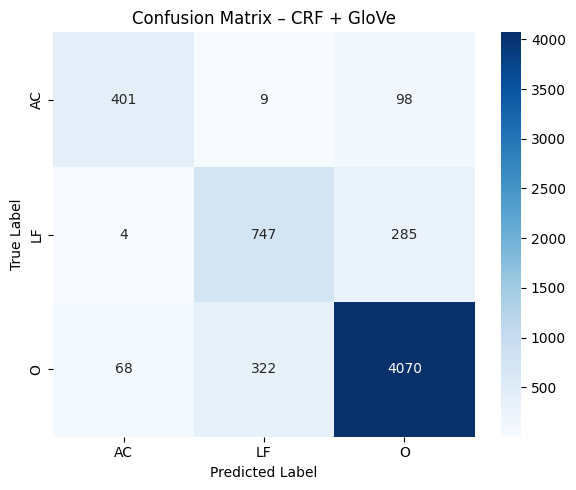

In [ ]:
def simplify(tag):
    if isinstance(tag, int):
        tag = dataset["train"].features["ner_tags"].feature.names[tag]
    if tag.endswith("AC"):
        return "AC"
    elif tag.endswith("LF"):
        return "LF"
    else:
        return "O"

y_val_flat = []
y_pred_flat = []
for true_seq, pred_seq in zip(y_val, y_pred):
    min_len = min(len(true_seq), len(pred_seq))
    true_seq = true_seq[:min_len]
    pred_seq = pred_seq[:min_len]

    y_val_flat.extend([simplify(tag) for tag in true_seq])
    y_pred_flat.extend([simplify(tag) for tag in pred_seq])

labels = ["AC", "LF", "O"]

cm = confusion_matrix(y_val_flat, y_pred_flat, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – CRF + GloVe")
plt.tight_layout()
plt.show()


In [ ]:
#Exp 2: CRF + Word2Vec

In [ ]:
!pip install numpy --upgrade
!pip install gensim --upgrade

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  A

In [ ]:
!pip install gensim

In [ ]:
import gensim.downloader as api


w2v_model = api.load("glove-wiki-gigaword-100")

In [ ]:
!pip install datasets sklearn-crfsuite gensim seqeval --quiet

In [ ]:
import numpy as np
import sklearn_crfsuite
from datasets import load_dataset
import gensim.downloader as api
from seqeval.metrics import precision_score, recall_score, f1_score

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")


w2v_model = api.load("glove-wiki-gigaword-300")

In [ ]:
def word2features_w2v(tokens, pos_tags, i):
    word = tokens[i]
    postag = pos_tags[i]


    w2v_vec = w2v_model[word.lower()] if word.lower() in w2v_model else np.zeros(300)

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.istitle()': word.istitle(),
        'word.isupper()': word.isupper(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
    }


    if i > 0:
        features.update({
            '-1:word.lower()': tokens[i-1].lower(),
            '-1:postag': pos_tags[i-1]
        })
    else:
        features['BOS'] = True


    if i < len(tokens) - 1:
        features.update({
            '+1:word.lower()': tokens[i+1].lower(),
            '+1:postag': pos_tags[i+1]
        })
    else:
        features['EOS'] = True


    for idx, val in enumerate(w2v_vec):
        features[f'w2v_{idx}'] = val

    return features

In [ ]:
def extract_features_w2v(dataset_split):
    return [
        [word2features_w2v(sample["tokens"], sample["pos_tags"], i)
         for i in range(len(sample["tokens"]))]
        for sample in dataset_split
    ]

def extract_labels(dataset_split):
    return [sample["ner_tags"] for sample in dataset_split]


X_train = extract_features_w2v(dataset["train"])
y_train = extract_labels(dataset["train"])

X_val = extract_features_w2v(dataset["validation"])
y_val = extract_labels(dataset["validation"])

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=200,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)
y_pred = crf.predict(X_val)

In [ ]:
def simplify(label):
    if label.endswith("AC"):
        return "AC"
    elif label.endswith("LF"):
        return "LF"
    else:
        return "O"


true_labels = [[simplify(tag) for tag in seq] for seq in y_val]
pred_labels = [[simplify(tag) for tag in seq] for seq in y_pred]

In [ ]:
flat_true, flat_pred = [], []

for t_seq, p_seq in zip(true_labels, pred_labels):
    for t, p in zip(t_seq, p_seq):
        if t in ["AC", "LF"]:
            flat_true.append(t)
            flat_pred.append(p)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

labels = ["AC", "LF"]


prec = precision_score(flat_true, flat_pred, labels=labels, average=None, zero_division=0)
rec = recall_score(flat_true, flat_pred, labels=labels, average=None, zero_division=0)
f1 = f1_score(flat_true, flat_pred, labels=labels, average=None, zero_division=0)
support = [flat_true.count(label) for label in labels]


print(f"{'':<14}{'precision':>10} {'recall':>8} {'f1-score':>10} {'support':>8}")
for i, label in enumerate(labels):
    print(f"{label:>14} {prec[i]:>10.2f} {rec[i]:>8.2f} {f1[i]:>10.2f} {support[i]:>8}")


micro_p = precision_score(flat_true, flat_pred, average='micro', zero_division=0)
micro_r = recall_score(flat_true, flat_pred, average='micro', zero_division=0)
micro_f1 = f1_score(flat_true, flat_pred, average='micro', zero_division=0)

macro_p = precision_score(flat_true, flat_pred, average='macro', zero_division=0)
macro_r = recall_score(flat_true, flat_pred, average='macro', zero_division=0)
macro_f1 = f1_score(flat_true, flat_pred, average='macro', zero_division=0)

weighted_p = precision_score(flat_true, flat_pred, average='weighted', zero_division=0)
weighted_r = recall_score(flat_true, flat_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(flat_true, flat_pred, average='weighted', zero_division=0)

total_support = sum(support)


print(f"\n{'micro avg':>14} {micro_p:>10.2f} {micro_r:>8.2f} {micro_f1:>10.2f} {total_support:>8}")
print(f"{'macro avg':>14} {macro_p:>10.2f} {macro_r:>8.2f} {macro_f1:>10.2f} {total_support:>8}")
print(f"{'weighted avg':>14} {weighted_p:>10.2f} {weighted_r:>8.2f} {weighted_f1:>10.2f} {total_support:>8}")


print(f"\nF1-score: {weighted_f1:.4f}")
print(f"Precision: {weighted_p:.4f}")
print(f"Recall: {weighted_r:.4f}")

               precision   recall   f1-score  support
            AC       0.99     0.78       0.87      508
            LF       0.99     0.73       0.84     1036

     micro avg       0.75     0.75       0.75     1544
     macro avg       0.66     0.50       0.57     1544
  weighted avg       0.99     0.75       0.85     1544

F1-score: 0.8503
Precision: 0.9889
Recall: 0.7461


Confusion Matrix:
[[396   8]
 [  5 756]]


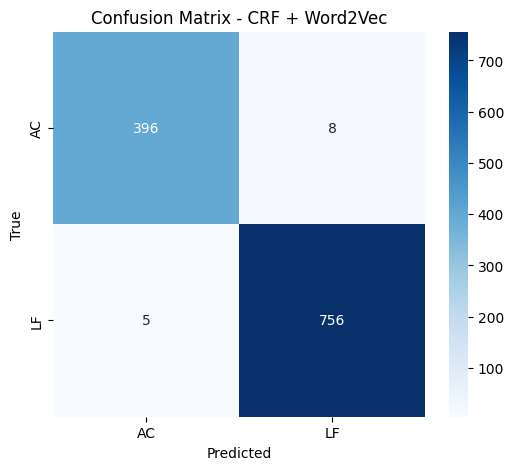

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(flat_true, flat_pred, labels=["AC", "LF"])

print("Confusion Matrix:")
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["AC", "LF"], yticklabels=["AC", "LF"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CRF + Word2Vec')
plt.show()


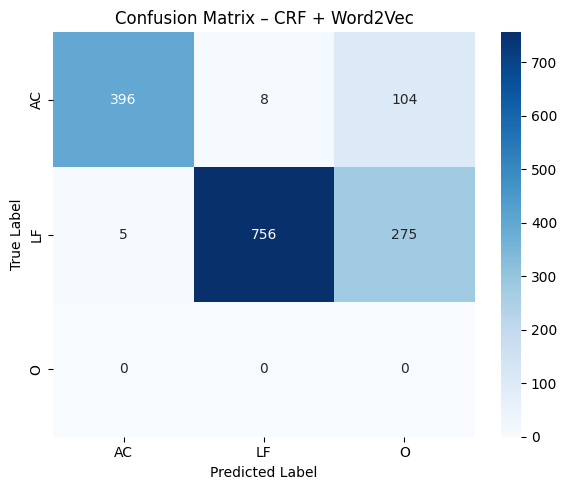

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["AC", "LF", "O"]

cm = confusion_matrix(flat_true, flat_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – CRF + Word2Vec")
plt.tight_layout()
plt.show()


In [ ]:
#Exp 3: BiLSTM + CRF with GloVe

In [ ]:
pip install datasets torch torchcrf seqeval

In [ ]:
from datasets import load_dataset

dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [ ]:
train_tokens = [sample["tokens"] for sample in dataset["train"]]
train_labels = [sample["ner_tags"] for sample in dataset["train"]]
val_tokens = [sample["tokens"] for sample in dataset["validation"]]
val_labels = [sample["ner_tags"] for sample in dataset["validation"]]

In [ ]:
def build_vocab(tokens_list):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for tokens in tokens_list:
        for token in tokens:
            token_lower = token.lower()
            if token_lower not in vocab:
                vocab[token_lower] = len(vocab)
    return vocab


def build_tag_vocab():
    tags = ["O", "B-AC", "B-LF", "I-LF"]
    return {tag: idx for idx, tag in enumerate(tags)}, {idx: tag for idx, tag in enumerate(tags)}

word2idx = build_vocab(train_tokens)
tag2idx, idx2tag = build_tag_vocab()

In [ ]:
import gensim.downloader as api


glove_vectors = api.load("glove-wiki-gigaword-100")

In [ ]:
import numpy as np

embedding_dim = 100
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

for word, idx in word2idx.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [ ]:
import torch
from torch.utils.data import Dataset

class TokenDataset(Dataset):
    def __init__(self, tokens_list, labels_list, word2idx, tag2idx, max_len):
        self.tokens_list = tokens_list
        self.labels_list = labels_list
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = self.tokens_list[idx]
        labels = self.labels_list[idx]


        token_ids = [self.word2idx.get(token.lower(), self.word2idx["<UNK>"]) for token in tokens]


        label_ids = [self.tag2idx[label] for label in labels]


        padding_length = self.max_len - len(token_ids)
        token_ids += [self.word2idx["<PAD>"]] * padding_length
        label_ids += [self.tag2idx["O"]] * padding_length

        return torch.tensor(token_ids), torch.tensor(label_ids)

In [ ]:
!pip install git+https://github.com/kmkurn/pytorch-crf.git

  Cloning https://github.com/kmkurn/pytorch-crf.git to /tmp/pip-req-build-1va2cjco
  Running command git clone --filter=blob:none --quiet https://github.com/kmkurn/pytorch-crf.git /tmp/pip-req-build-1va2cjco
  Resolved https://github.com/kmkurn/pytorch-crf.git to commit 623e3402d00a2728e99d6e8486010d67c754267b
  Preparing metadata (setup.py) ... done


In [ ]:
import torch.nn as nn
import torchcrf

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_matrix, hidden_dim=256):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=0)
        self.bilstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = torchcrf.CRF(tagset_size, batch_first=True)

    def forward(self, sentences, labels=None):
        embeds = self.embedding(sentences)
        lstm_out, _ = self.bilstm(embeds)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            loss = -self.crf(emissions, labels, mask=sentences != 0)
            return loss
        else:
            preds = self.crf.decode(emissions, mask=sentences != 0)
            return preds

In [ ]:
from torch.utils.data import DataLoader

max_len = 128
batch_size = 32

max_len = max(max(len(tokens) for tokens in train_tokens), max(len(tokens) for tokens in val_tokens))
print(f"Calculated max_len: {max_len}")

train_dataset = TokenDataset(train_tokens, train_labels, word2idx, tag2idx, max_len)
val_dataset = TokenDataset(val_tokens, val_labels, word2idx, tag2idx, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM_CRF(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    embedding_matrix=embedding_matrix
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Calculated max_len: 371


In [ ]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, optimizer, n_epochs=10):
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for tokens, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            tokens, labels = tokens.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = model(tokens, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader)}")

train_model(model, train_loader, val_loader, optimizer, n_epochs=10)

Training Epoch 1: 100%|██████████| 63/63 [02:09<00:00,  2.05s/it]


Epoch 1 Loss: 924.4018806578621


Training Epoch 2: 100%|██████████| 63/63 [00:54<00:00,  1.15it/s]


Epoch 2 Loss: 512.664048936632


Training Epoch 3: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s]


Epoch 3 Loss: 379.6288846939329


Training Epoch 4: 100%|██████████| 63/63 [00:54<00:00,  1.16it/s]


Epoch 4 Loss: 315.6703839983259


Training Epoch 5: 100%|██████████| 63/63 [00:54<00:00,  1.15it/s]


Epoch 5 Loss: 266.8974139501178


Training Epoch 6: 100%|██████████| 63/63 [00:54<00:00,  1.16it/s]


Epoch 6 Loss: 221.35755714537606


Training Epoch 7: 100%|██████████| 63/63 [00:54<00:00,  1.15it/s]


Epoch 7 Loss: 189.6457274906219


Training Epoch 8: 100%|██████████| 63/63 [00:58<00:00,  1.08it/s]


Epoch 8 Loss: 152.21642945304748


Training Epoch 9: 100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 9 Loss: 122.94102574908544


Training Epoch 10: 100%|██████████| 63/63 [00:54<00:00,  1.16it/s]

Epoch 10 Loss: 98.47621790568034


In [ ]:
from tqdm import tqdm

def predict(model, val_loader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for tokens, labels in tqdm(val_loader, desc="Predicting"):
            tokens = tokens.to(device)
            labels = labels.to(device)


            output = model(tokens)


            predictions.extend(output)


            true_labels.extend(labels.cpu().numpy().tolist())

    return predictions, true_labels


predictions, true_labels = predict(model, val_loader, device)

Predicting: 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


In [ ]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for tokens, labels in val_loader:
        tokens = tokens.to(device)
        outputs = model(tokens)
        all_preds.extend(outputs)
        all_true.extend(labels.cpu().numpy().tolist())

In [ ]:
def decode_predictions(preds, idx2tag):
    decoded = []
    for seq in preds:
        decoded.append([idx2tag[idx] for idx in seq])
    return decoded

true_labels = decode_predictions(all_true, idx2tag)
pred_labels = decode_predictions(all_preds, idx2tag)

In [ ]:
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score


min_len = min(len(true_labels), len(pred_labels))
true_labels = true_labels[:min_len]
pred_labels = pred_labels[:min_len]


for i in range(min_len):
    min_seq_len = min(len(true_labels[i]), len(pred_labels[i]))
    true_labels[i] = true_labels[i][:min_seq_len]
    pred_labels[i] = pred_labels[i][:min_seq_len]


print(classification_report(true_labels, pred_labels))
print("Precision:", precision_score(true_labels, pred_labels))
print("Recall:", recall_score(true_labels, pred_labels))
print("F1 Score:", f1_score(true_labels, pred_labels))

              precision    recall  f1-score   support

          AC       0.53      0.81      0.64       508
          LF       0.54      0.63      0.59       306

   micro avg       0.54      0.75      0.62       814
   macro avg       0.54      0.72      0.61       814
weighted avg       0.54      0.75      0.62       814

Precision: 0.5356828193832599
Recall: 0.7469287469287469
F1 Score: 0.6239096972806567


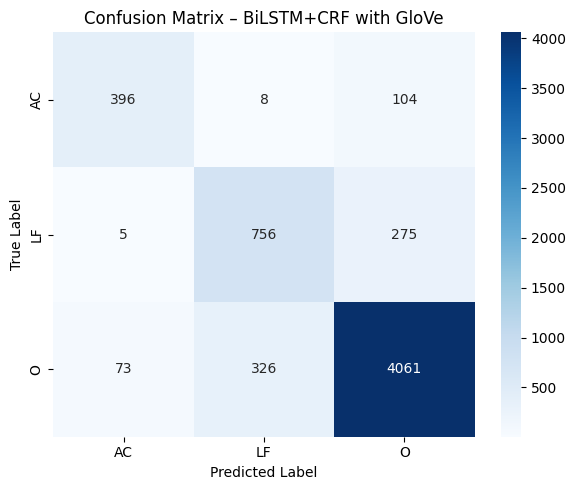

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def simplify(tag):
    if tag.endswith("AC"):
        return "AC"
    elif tag.endswith("LF"):
        return "LF"
    else:
        return "O"

flat_true = [simplify(tag) for seq in true_labels for tag in seq]
flat_pred = [simplify(tag) for seq in pred_labels for tag in seq]

labels = ["AC", "LF", "O"]

cm = confusion_matrix(flat_true, flat_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – BiLSTM+CRF with GloVe")
plt.tight_layout()
plt.show()


In [ ]:
#Exp 4: BiLSTM + CRF with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def build_tag_vocab():
    tags = ["O", "B-AC", "B-LF", "I-LF"]
    return {tag: idx for idx, tag in enumerate(tags)}, {idx: tag for idx, tag in enumerate(tags)}

tag2idx, idx2tag = build_tag_vocab()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_tokens = [sample["tokens"] for sample in dataset["train"]]
train_labels = [sample["ner_tags"] for sample in dataset["train"]]
val_tokens = [sample["tokens"] for sample in dataset["validation"]]
val_labels = [sample["ner_tags"] for sample in dataset["validation"]]

train_sentences = [" ".join(tokens) for tokens in train_tokens]
val_sentences = [" ".join(tokens) for tokens in val_tokens]

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_sentences).toarray()
X_val_tfidf = vectorizer.transform(val_sentences).toarray()

In [ ]:
import torch
from torch.utils.data import Dataset

class TfidfDataset(Dataset):
    def __init__(self, X, labels_list, tag2idx):
        self.X = X
        self.labels_list = labels_list
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        labels = self.labels_list[idx]
        label_ids = [self.tag2idx.get(labels[0], self.tag2idx["O"])]  # Only first label
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label_ids, dtype=torch.long)

In [ ]:
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_CRF_TFIDF(nn.Module):
    def __init__(self, input_dim, tagset_size, hidden_dim=256):
        super(BiLSTM_CRF_TFIDF, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, features, labels=None):
        features = features.unsqueeze(1)
        lstm_out, _ = self.lstm(features)
        emissions = self.fc(lstm_out)

        if labels is not None:
            return -self.crf(emissions, labels)
        else:
            return self.crf.decode(emissions)

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

train_dataset = TfidfDataset(X_train_tfidf, train_labels, tag2idx)
val_dataset = TfidfDataset(X_val_tfidf, val_labels, tag2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM_CRF_TFIDF(input_dim=5000, tagset_size=len(tag2idx)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, optimizer, n_epochs=10):
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            loss = model(features, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            preds = model(features)
            all_preds.extend([p[0] for p in preds])
            all_labels.extend(labels.squeeze().tolist())

    y_true = [idx2tag[idx] for idx in all_labels]
    y_pred = [idx2tag[idx] for idx in all_preds]
    print(classification_report(y_true, y_pred, labels=["B-AC", "B-LF"]))
    print("Precision:", precision_score(y_true, y_pred, average="micro"))
    print("Recall:", recall_score(y_true, y_pred, average="micro"))
    print("F1 Score:", f1_score(y_true, y_pred, average="micro"))

train_model(model, train_loader, optimizer, n_epochs=10)
evaluate_model(model, val_loader)

Epoch 1 Loss: 34.2343
Epoch 2 Loss: 22.8229
Epoch 3 Loss: 17.0599
Epoch 4 Loss: 12.1988
Epoch 5 Loss: 8.4694
Epoch 6 Loss: 5.3342
Epoch 7 Loss: 3.2319
Epoch 8 Loss: 2.0588
Epoch 9 Loss: 1.4230
Epoch 10 Loss: 1.0429
              precision    recall  f1-score   support

        B-AC       0.76      0.47      0.58        40
        B-LF       0.20      0.14      0.17        14

   micro avg       0.60      0.39      0.47        54
   macro avg       0.48      0.31      0.38        54
weighted avg       0.61      0.39      0.48        54

Precision: 0.7133333333333334
Recall: 0.7133333333333334
F1 Score: 0.7133333333333334


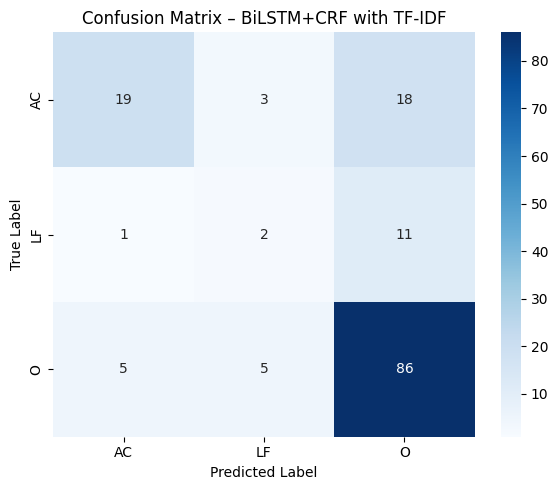

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def simplify(tag):
    if tag.endswith("AC"):
        return "AC"
    elif tag.endswith("LF"):
        return "LF"
    else:
        return "O"


def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            preds = model(features)
            all_preds.extend([p[0] for p in preds])
            all_labels.extend(labels.squeeze().tolist())

    y_true = [simplify(idx2tag[idx]) for idx in all_labels]
    y_pred = [simplify(idx2tag[idx]) for idx in all_preds]
    return y_true, y_pred, all_labels, all_preds


y_true, y_pred, all_labels, all_preds = evaluate_model(model, val_loader)

labels = ["AC", "LF", "O"]

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – BiLSTM+CRF with TF-IDF")
plt.tight_layout()
plt.show()

In [ ]:
#Exp 5: BERT (Fine-Tuned)

In [ ]:
!pip install --upgrade transformers

In [ ]:
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
labels_list = ['O', 'B-AC', 'B-LF', 'I-LF']
label2id = {label: idx for idx, label in enumerate(labels_list)}
id2label = {idx: label for idx, label in enumerate(labels_list)}

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        is_split_into_words=True,
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:

                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_preds = []

    for pred, label in zip(predictions, labels):
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                true_labels.append(id2label[l_])
                true_preds.append(id2label[p_])

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_preds, average="weighted")
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-finetuned-plod",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    report_to="none"
)

In [ ]:
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

<ipython-input-24-dbf98af767e0>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.218500,0.261979,0.910989,0.903563,0.905849
2,0.178100,0.258386,0.917112,0.909901,0.912025
3,0.163800,0.258104,0.914089,0.910072,0.911475
4,0.142900,0.275471,0.917310,0.910243,0.912343
5,0.120100,0.279843,0.916330,0.910072,0.912013


TrainOutput(global_step=625, training_loss=0.19154211082458497, metrics={'train_runtime': 12458.0324, 'train_samples_per_second': 0.803, 'train_steps_per_second': 0.05, 'total_flos': 653253703680000.0, 'train_loss': 0.19154211082458497, 'epoch': 5.0})

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["validation"])
predictions = np.argmax(predictions, axis=2)

true_labels = []
true_predictions = []
for pred, label in zip(predictions, labels):
    for p, l in zip(pred, label):
        if l != -100:
            true_labels.append(id2label[l])
            true_predictions.append(id2label[p])

def simplify_label(label):
    if label.endswith('AC'):
        return 'AC'
    elif label.endswith('LF'):
        return 'LF'
    else:
        return 'O'

simple_true = [simplify_label(l) for l in true_labels]
simple_pred = [simplify_label(p) for p in true_predictions]

mask = [(t in ["AC", "LF"]) or (p in ["AC", "LF"]) for t, p in zip(simple_true, simple_pred)]
filtered_true = [t for i, t in enumerate(simple_true) if mask[i]]
filtered_pred = [p for i, p in enumerate(simple_pred) if mask[i]]

labels_eval = ["AC", "LF"]
prec, rec, f1, support = precision_recall_fscore_support(filtered_true, filtered_pred, labels=labels_eval, zero_division=0)

micro_p = precision_score(filtered_true, filtered_pred, average='micro', zero_division=0)
micro_r = recall_score(filtered_true, filtered_pred, average='micro', zero_division=0)
micro_f1 = f1_score(filtered_true, filtered_pred, average='micro', zero_division=0)

macro_p = precision_score(filtered_true, filtered_pred, average='macro', zero_division=0)
macro_r = recall_score(filtered_true, filtered_pred, average='macro', zero_division=0)
macro_f1 = f1_score(filtered_true, filtered_pred, average='macro', zero_division=0)

weighted_p = precision_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
weighted_r = recall_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(filtered_true, filtered_pred, average='weighted', zero_division=0)

print(f"{'':<15}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support'}")
for i, label in enumerate(labels_eval):
    print(f"{label:<15}{prec[i]:<10.2f}{rec[i]:<10.2f}{f1[i]:<10.2f}{support[i]}")

print(f"\n{'micro avg':<15}{micro_p:<10.2f}{micro_r:<10.2f}{micro_f1:<10.2f}{sum(support)}")
print(f"{'macro avg':<15}{macro_p:<10.2f}{macro_r:<10.2f}{macro_f1:<10.2f}{sum(support)}")
print(f"{'weighted avg':<15}{weighted_p:<10.2f}{weighted_r:<10.2f}{weighted_f1:<10.2f}{sum(support)}")

print("\nPrecision:", weighted_p)
print("Recall:", weighted_r)
print("F1 Score:", weighted_f1)


               precision recall    f1-score  support
AC             0.83      0.90      0.86      493
LF             0.78      0.90      0.84      1028

micro avg      0.73      0.73      0.73      1521
macro avg      0.54      0.60      0.57      1521
weighted avg   0.65      0.73      0.69      1521

Precision: 0.6518360807231232
Recall: 0.7344420600858369
F1 Score: 0.6905460272701371


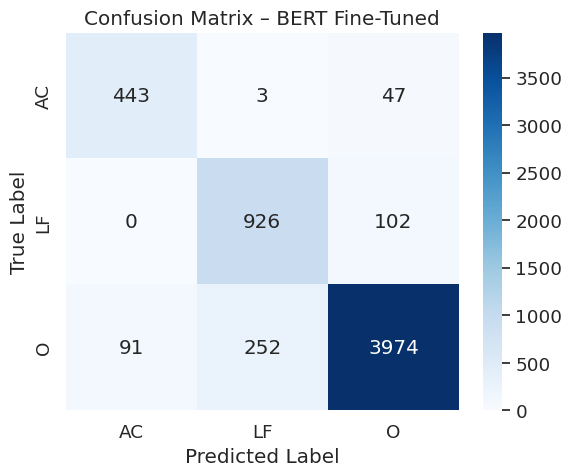

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["AC", "LF", "O"]

cm = confusion_matrix(simple_true, simple_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – BERT Fine-Tuned")
plt.tight_layout()
plt.show()

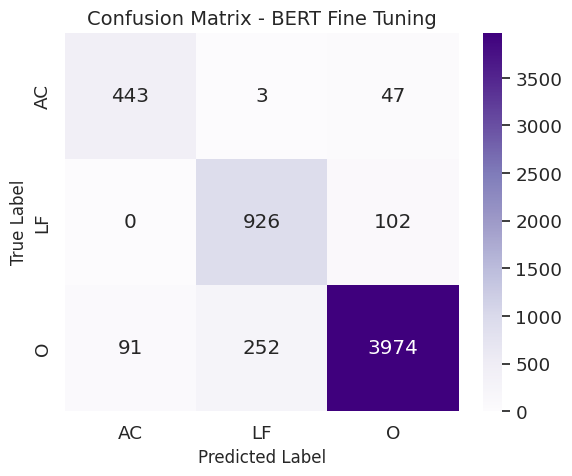

In [ ]:
labels_cm = ["AC", "LF", "O"]
cm = confusion_matrix(simple_true, simple_pred, labels=labels_cm)
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=labels_cm, yticklabels=labels_cm)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - BERT Fine Tuning", fontsize=14)
plt.tight_layout()
plt.savefig("bert_confusion_matrix.png", dpi=300)
plt.show()

In [ ]:
#Exp 6: BERT with Optimizers

In [ ]:
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from torch.optim import AdamW
from transformers import Adafactor
import torch
from torch import optim

In [ ]:
labels_list = ['O', 'B-AC', 'B-LF', 'I-LF']

label2id = {label: idx for idx, label in enumerate(labels_list)}
id2label = {idx: label for idx, label in enumerate(labels_list)}

In [ ]:
from transformers import BertTokenizerFast, BertForTokenClassification

model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id
)

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
!pip install datasets
from datasets import load_dataset
from transformers import BertTokenizerFast

dataset = load_dataset("surrey-nlp/PLOD-CW-25")

labels_list = ['O', 'B-AC', 'B-LF', 'I-LF']
label2id = {label: idx for idx, label in enumerate(labels_list)}
id2label = {idx: label for idx, label in enumerate(labels_list)}


tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        is_split_into_words=True,
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_preds = []

    for pred, label in zip(predictions, labels):
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                true_labels.append(id2label[l_])
                true_preds.append(id2label[p_])

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, true_preds, average="weighted", zero_division=0
    )

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-optimizer-test",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    report_to="none"
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    optimizers=(optimizer, None),
    compute_metrics=compute_metrics
)

<ipython-input-10-a7e9f1992775>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.209800,0.259430,0.913543,0.906817,0.908829
2,0.177900,0.261297,0.917601,0.910928,0.912975
3,0.160900,0.258884,0.916458,0.912299,0.913725
4,0.145000,0.270035,0.918210,0.910757,0.912926
5,0.116000,0.276139,0.918105,0.911785,0.913717


TrainOutput(global_step=625, training_loss=0.19252341089248656, metrics={'train_runtime': 13788.9858, 'train_samples_per_second': 0.725, 'train_steps_per_second': 0.045, 'total_flos': 653253703680000.0, 'train_loss': 0.19252341089248656, 'epoch': 5.0})

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["validation"])
predictions = np.argmax(predictions, axis=2)

true_labels = []
true_preds = []
for pred, label in zip(predictions, labels):
    for p_, l_ in zip(pred, label):
        if l_ != -100:
            true_labels.append(id2label[l_])
            true_preds.append(id2label[p_])

def simplify(label):
    if label.endswith("AC"):
        return "AC"
    elif label.endswith("LF"):
        return "LF"
    else:
        return "O"

simple_true = [simplify(l) for l in true_labels]
simple_pred = [simplify(p) for p in true_preds]

mask = [(t in ["AC", "LF"]) or (p in ["AC", "LF"]) for t, p in zip(simple_true, simple_pred)]
filtered_true = [t for i, t in enumerate(simple_true) if mask[i]]
filtered_pred = [p for i, p in enumerate(simple_pred) if mask[i]]

labels_eval = ["AC", "LF"]
prec, rec, f1, support = precision_recall_fscore_support(filtered_true, filtered_pred, labels=labels_eval, zero_division=0)

micro_p = precision_score(filtered_true, filtered_pred, average='micro', zero_division=0)
micro_r = recall_score(filtered_true, filtered_pred, average='micro', zero_division=0)
micro_f1 = f1_score(filtered_true, filtered_pred, average='micro', zero_division=0)

macro_p = precision_score(filtered_true, filtered_pred, average='macro', zero_division=0)
macro_r = recall_score(filtered_true, filtered_pred, average='macro', zero_division=0)
macro_f1 = f1_score(filtered_true, filtered_pred, average='macro', zero_division=0)

weighted_p = precision_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
weighted_r = recall_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(filtered_true, filtered_pred, average='weighted', zero_division=0)

print(f"{'':<15}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support'}")
for i, label in enumerate(labels_eval):
    print(f"{label:<15}{prec[i]:<10.2f}{rec[i]:<10.2f}{f1[i]:<10.2f}{support[i]}")

print(f"\n{'micro avg':<15}{micro_p:<10.2f}{micro_r:<10.2f}{micro_f1:<10.2f}{sum(support)}")
print(f"{'macro avg':<15}{macro_p:<10.2f}{macro_r:<10.2f}{macro_f1:<10.2f}{sum(support)}")
print(f"{'weighted avg':<15}{weighted_p:<10.2f}{weighted_r:<10.2f}{weighted_f1:<10.2f}{sum(support)}")

print("\nPrecision:", weighted_p)
print("Recall:", weighted_r)
print("F1 Score:", weighted_f1)

               precision recall    f1-score  support
AC             0.83      0.89      0.86      493
LF             0.79      0.91      0.84      1028

micro avg      0.74      0.74      0.74      1521
macro avg      0.54      0.60      0.57      1521
weighted avg   0.65      0.74      0.69      1521

Precision: 0.6545723629863908
Recall: 0.738850080601827
F1 Score: 0.694005873122007


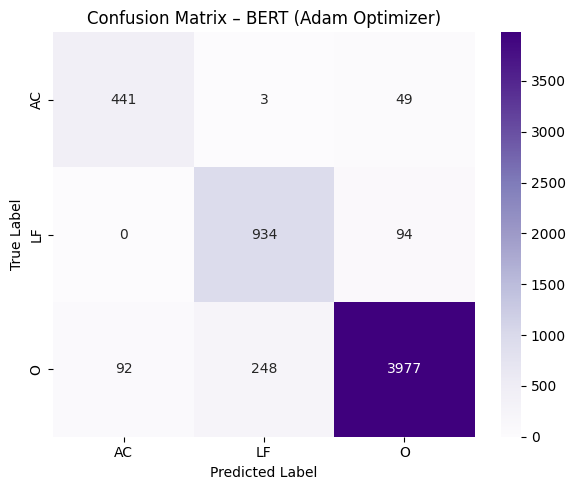

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels_all = ["AC", "LF", "O"]
cm = confusion_matrix(simple_true, simple_pred, labels=labels_all)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=labels_all, yticklabels=labels_all)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – BERT (Adam Optimizer)")
plt.tight_layout()
plt.savefig("bert_optimizer_confusion_matrix.png", dpi=300)
plt.show()


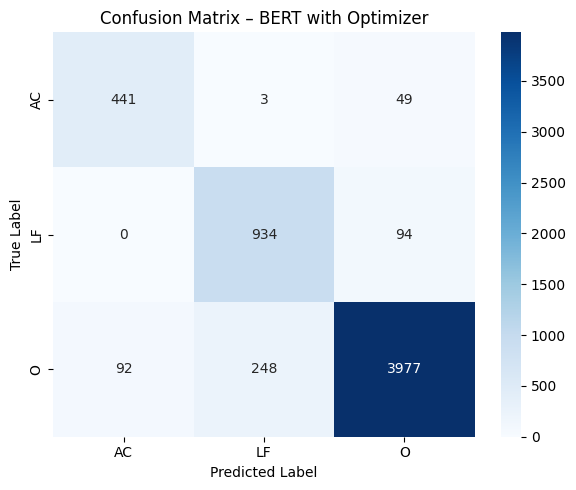

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["AC", "LF", "O"]

cm = confusion_matrix(simple_true, simple_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – BERT with Optimizer")
plt.tight_layout()
plt.show()

In [ ]:
#Exp 7: RoBERTa (Fine-Tuned)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
labels_list = ['O', 'B-AC', 'B-LF', 'I-LF']
label2id = {label: idx for idx, label in enumerate(labels_list)}
id2label = {idx: label for idx, label in enumerate(labels_list)}

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        is_split_into_words=True,
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_preds = []

    for pred, label in zip(predictions, labels):
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                true_labels.append(id2label[l_])
                true_preds.append(id2label[p_])

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_preds, average="weighted", zero_division=0)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
model = RobertaForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./roberta-finetuned-plod",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-12-1a28b5d5a597>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.185300,0.246020,0.918074,0.912404,0.914152


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.185300,0.246020,0.918074,0.912404,0.914152
2,0.156500,0.265716,0.921639,0.912062,0.914590
3,0.158400,0.234738,0.921371,0.917194,0.918524
4,0.136500,0.257693,0.923874,0.914286,0.916747
5,0.112500,0.254145,0.924344,0.915997,0.918187


TrainOutput(global_step=625, training_loss=0.18080022287368774, metrics={'train_runtime': 14004.8792, 'train_samples_per_second': 0.714, 'train_steps_per_second': 0.045, 'total_flos': 653253703680000.0, 'train_loss': 0.18080022287368774, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score, classification_report

predictions, labels, _ = trainer.predict(tokenized_dataset["validation"])
predictions = np.argmax(predictions, axis=2)

true_labels = []
true_preds = []

for pred, label in zip(predictions, labels):
    for p_, l_ in zip(pred, label):
        if l_ != -100:
            true_labels.append(id2label[l_])
            true_preds.append(id2label[p_])

def simplify(label):
    if label.endswith("AC"):
        return "AC"
    elif label.endswith("LF"):
        return "LF"
    else:
        return "O"

simple_true = [simplify(l) for l in true_labels]
simple_pred = [simplify(p) for p in true_preds]

labels = ["AC", "LF"]

prec, rec, f1, support = precision_recall_fscore_support(
    simple_true, simple_pred, labels=labels, zero_division=0
)

micro_p = precision_score(simple_true, simple_pred, labels=labels, average='micro', zero_division=0)
micro_r = recall_score(simple_true, simple_pred, labels=labels, average='micro', zero_division=0)
micro_f1 = f1_score(simple_true, simple_pred, labels=labels, average='micro', zero_division=0)

macro_p = precision_score(simple_true, simple_pred, labels=labels, average='macro', zero_division=0)
macro_r = recall_score(simple_true, simple_pred, labels=labels, average='macro', zero_division=0)
macro_f1 = f1_score(simple_true, simple_pred, labels=labels, average='macro', zero_division=0)

weighted_p = precision_score(simple_true, simple_pred, labels=labels, average='weighted', zero_division=0)
weighted_r = recall_score(simple_true, simple_pred, labels=labels, average='weighted', zero_division=0)
weighted_f1 = f1_score(simple_true, simple_pred, labels=labels, average='weighted', zero_division=0)

print(f"{'':<15}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support'}")
for i, label in enumerate(labels):
    print(f"{label:<15}{prec[i]:<10.2f}{rec[i]:<10.2f}{f1[i]:<10.2f}{support[i]}")

print(f"\n{'micro avg':<15}{micro_p:<10.2f}{micro_r:<10.2f}{micro_f1:<10.2f}{sum(support)}")
print(f"{'macro avg':<15}{macro_p:<10.2f}{macro_r:<10.2f}{macro_f1:<10.2f}{sum(support)}")
print(f"{'weighted avg':<15}{weighted_p:<10.2f}{weighted_r:<10.2f}{weighted_f1:<10.2f}{sum(support)}")

print("\nPrecision:", weighted_p)
print("Recall:", weighted_r)
print("F1 Score:", weighted_f1)


               precision recall    f1-score  support
AC             0.83      0.89      0.86      493
LF             0.78      0.94      0.86      1029

micro avg      0.80      0.93      0.86      1522
macro avg      0.81      0.92      0.86      1522
weighted avg   0.80      0.93      0.86      1522

Precision: 0.7981863698649392
Recall: 0.9250985545335085
F1 Score: 0.8562364829715227


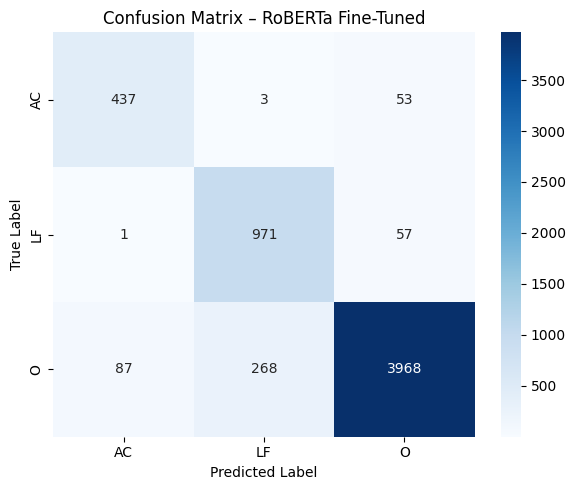

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["AC", "LF", "O"]

cm = confusion_matrix(simple_true, simple_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – RoBERTa Fine-Tuned")
plt.tight_layout()
plt.show()

In [ ]:
#Exp 8: RoBERTa with Optimizers

In [ ]:
!pip install transformers
!pip install datasets
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments
from torch.optim import AdamW, SGD
from transformers import Adafactor
from datasets import load_dataset
import numpy as np
from sklearn.metrics import precision_recall_fscore_support


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
labels_list = ['O', 'B-AC', 'B-LF', 'I-LF']
label2id = {label: idx for idx, label in enumerate(labels_list)}
id2label = {idx: label for idx, label in enumerate(labels_list)}

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        is_split_into_words=True,
        max_length=128
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_preds = []

    for pred, label in zip(predictions, labels):
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                true_labels.append(id2label[l_])
                true_preds.append(id2label[p_])

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_preds, average="weighted", zero_division=0)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./roberta-optimizer-test",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    report_to="none"
)

In [ ]:
model = RobertaForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)
)

trainer.train()

<ipython-input-9-985a5bbc3862>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.176900,0.252904,0.918136,0.911891,0.913764
2,0.157700,0.276540,0.922282,0.911891,0.914568
3,0.157600,0.240729,0.921323,0.916339,0.917904
4,0.130500,0.260234,0.924178,0.916339,0.918497
5,0.114700,0.263030,0.923371,0.916510,0.918457


TrainOutput(global_step=625, training_loss=0.17854113597869872, metrics={'train_runtime': 12930.314, 'train_samples_per_second': 0.773, 'train_steps_per_second': 0.048, 'total_flos': 653253703680000.0, 'train_loss': 0.17854113597869872, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
from collections import Counter
import numpy as np

predictions, labels, _ = trainer.predict(tokenized_dataset["validation"])
predictions = np.argmax(predictions, axis=2)

true_labels = []
true_preds = []

for pred, label in zip(predictions, labels):
    for p_, l_ in zip(pred, label):
        if l_ != -100:
            true_labels.append(id2label[l_])
            true_preds.append(id2label[p_])

def simplify(label):
    if label.endswith("AC"):
        return "AC"
    elif label.endswith("LF"):
        return "LF"
    else:
        return "O"

simple_true = [simplify(l) for l in true_labels]
simple_pred = [simplify(p) for p in true_preds]

mask = [(t in ["AC", "LF"]) or (p in ["AC", "LF"]) for t, p in zip(simple_true, simple_pred)]
filtered_true = [t for i, t in enumerate(simple_true) if mask[i]]
filtered_pred = [p for i, p in enumerate(simple_pred) if mask[i]]

print("Predicted label distribution:", Counter(filtered_pred))
print("True label distribution:", Counter(filtered_true))

labels = ["AC", "LF"]
prec, rec, f1, support = precision_recall_fscore_support(filtered_true, filtered_pred, labels=labels, zero_division=0)

micro_p = precision_score(filtered_true, filtered_pred, average='micro', zero_division=0)
micro_r = recall_score(filtered_true, filtered_pred, average='micro', zero_division=0)
micro_f1 = f1_score(filtered_true, filtered_pred, average='micro', zero_division=0)

macro_p = precision_score(filtered_true, filtered_pred, average='macro', zero_division=0)
macro_r = recall_score(filtered_true, filtered_pred, average='macro', zero_division=0)
macro_f1 = f1_score(filtered_true, filtered_pred, average='macro', zero_division=0)

weighted_p = precision_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
weighted_r = recall_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(filtered_true, filtered_pred, average='weighted', zero_division=0)

print(f"\n{'':<15}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support'}")
for i, label in enumerate(labels):
    print(f"{label:<15}{prec[i]:<10.2f}{rec[i]:<10.2f}{f1[i]:<10.2f}{support[i]}")

print(f"\n{'micro avg':<15}{micro_p:<10.2f}{micro_r:<10.2f}{micro_f1:<10.2f}{sum(support)}")
print(f"{'macro avg':<15}{macro_p:<10.2f}{macro_r:<10.2f}{macro_f1:<10.2f}{sum(support)}")
print(f"{'weighted avg':<15}{weighted_p:<10.2f}{weighted_r:<10.2f}{weighted_f1:<10.2f}{sum(support)}")

print("\nPrecision:", weighted_p)
print("Recall:", weighted_r)
print("F1 Score:", weighted_f1)

Predicted label distribution: Counter({'LF': 1210, 'AC': 524, 'O': 124})
True label distribution: Counter({'LF': 1029, 'AC': 493, 'O': 336})

               precision recall    f1-score  support
AC             0.84      0.89      0.86      493
LF             0.79      0.93      0.85      1029

micro avg      0.75      0.75      0.75      1522
macro avg      0.54      0.61      0.57      1522
weighted avg   0.66      0.75      0.70      1522

Precision: 0.659862038361955
Recall: 0.7508073196986006
F1 Score: 0.7020106406051613


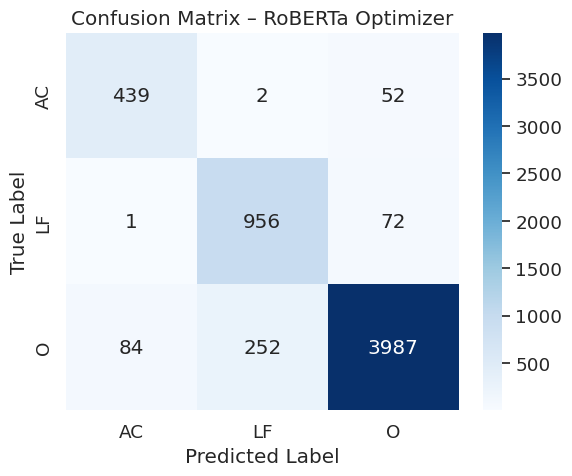

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["AC", "LF", "O"]

cm = confusion_matrix(simple_true, simple_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – RoBERTa Optimizer")
plt.tight_layout()
plt.show()

In [ ]:
#Comparison between all experiments


===== Model Comparison =====

                        Experiment  Precision  Recall  F1-Score
0               Exp 1: CRF + GloVe     0.7630  0.7199    0.7408
1            Exp 2: CRF + Word2Vec     0.9889  0.7461    0.8503
2   Exp 3: BiLSTM + CRF with GloVe     0.5357  0.7469    0.6239
3  Exp 4: BiLSTM + CRF with TF-IDF     0.7133  0.7133    0.7133
4         Exp 5: BERT (fine-tuned)     0.6518  0.7344    0.6905
5          Exp 6: BERT + Optimizer     0.6546  0.7389    0.6940
6      Exp 7: RoBERTa (fine-tuned)     0.7982  0.9251    0.8562
7       Exp 8: RoBERTa + Optimizer     0.6599  0.7508    0.7020


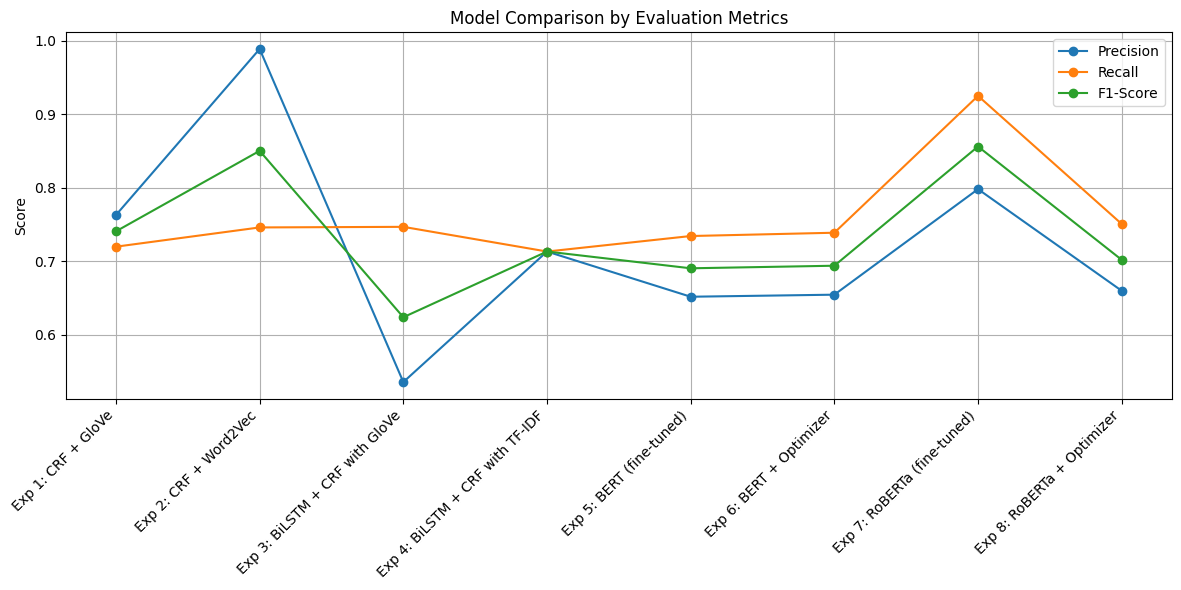

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Experiment": [
        "Exp 1: CRF + GloVe",
        "Exp 2: CRF + Word2Vec",
        "Exp 3: BiLSTM + CRF with GloVe",
        "Exp 4: BiLSTM + CRF with TF-IDF",
        "Exp 5: BERT (fine-tuned)",
        "Exp 6: BERT + Optimizer",
        "Exp 7: RoBERTa (fine-tuned)",
        "Exp 8: RoBERTa + Optimizer"
    ],
    "Precision": [
        0.7630,
        0.9889,
        0.5357,
        0.7133,
        0.6518,
        0.6546,
        0.7982,
        0.6599
    ],
    "Recall": [
        0.7199,
        0.7461,
        0.7469,
        0.7133,
        0.7344,
        0.7389,
        0.9251,
        0.7508
    ],
    "F1-Score": [
        0.7408,
        0.8503,
        0.6239,
        0.7133,
        0.6905,
        0.6940,
        0.8562,
        0.7020
    ]
}

df = pd.DataFrame(data)

print("\n===== Model Comparison =====\n")
print(df)

plt.figure(figsize=(12, 6))
plt.plot(df["Experiment"], df["Precision"], marker='o', label="Precision")
plt.plot(df["Experiment"], df["Recall"], marker='o', label="Recall")
plt.plot(df["Experiment"], df["F1-Score"], marker='o', label="F1-Score")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Model Comparison by Evaluation Metrics")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


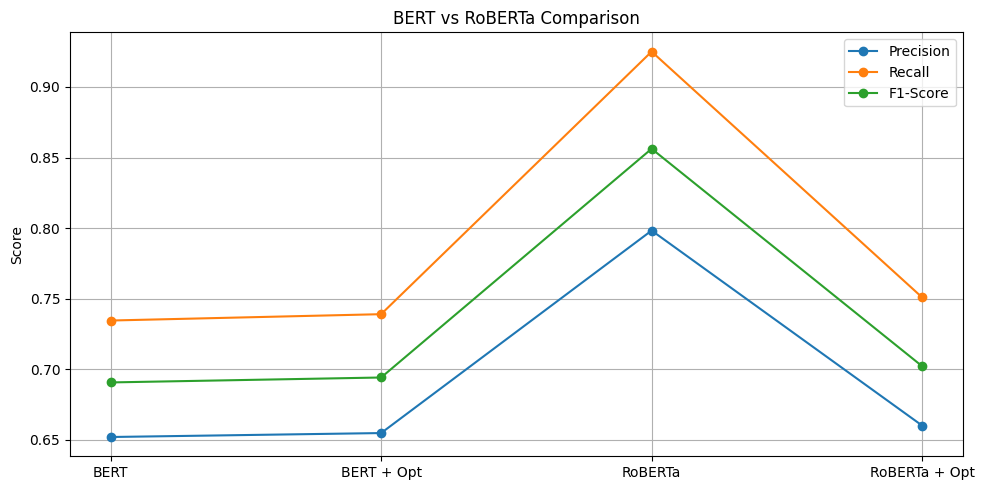

In [ ]:
import matplotlib.pyplot as plt

models = ["BERT", "BERT + Opt", "RoBERTa", "RoBERTa + Opt"]
precision = [0.6518, 0.6546, 0.7982, 0.6599]
recall =    [0.7344, 0.7389, 0.9251, 0.7508]
f1_score =  [0.6905, 0.6940, 0.8562, 0.7020]

plt.figure(figsize=(10, 5))
plt.plot(models, precision, marker='o', label="Precision")
plt.plot(models, recall, marker='o', label="Recall")
plt.plot(models, f1_score, marker='o', label="F1-Score")
plt.title("BERT vs RoBERTa Comparison")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#implementing gradio ui for the best model(RoBERTa fine-tuned)

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def predict_tags(sentence):
    tokens = sentence.strip().split()
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)

    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)

    word_ids = inputs.word_ids()
    pred_labels = []
    prev_word_id = None
    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if word_id != prev_word_id:
            pred_labels.append(id2label[predictions[0][idx].item()])
            prev_word_id = word_id

    return list(zip(tokens, pred_labels))

demo = gr.Interface(
    fn=predict_tags,
    inputs=gr.Textbox(lines=3, placeholder="Enter a biomedical sentence..."),
    outputs="json",
    title="Abbreviation and Long-Form Detection (RoBERTa)",
    description="Enter a sentence and get BIO tag predictions for abbreviations (AC) and long forms (LF)."
)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5495b46f82982bab6a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
